In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [5]:
oil_data= pd.read_csv('synthetic_oil_data.csv')
oil_data.head(5)
#print(oil_data.shape)

,Rock_Type,Porosity,Permeability,Trap_Type,Seismic_Score,Proximity_to_Oil_Field,Estimated_Reservoir_Depth,Oil_Presence
0,Shale,0.438848,903.714252,NaN,0.181881,4.226811,1547,0
1,Sandstone,6.217269,111.883819,Fault,0.169586,0.583624,4878,0
2,Shale,21.397076,177.944336,NaN,0.862800,0.180588,1815,0
3,Shale,11.598605,429.236160,Dome,0.498148,3.042691,1886,0
4,Sandstone,19.874518,127.586022,Anticline,0.245937,1.708715,4420,0


In [6]:
oil_data.isnull().sum()

Rock_Type                       0
Porosity                        0
Permeability                    0
Trap_Type                    1253
Seismic_Score                   0
Proximity_to_Oil_Field          0
Estimated_Reservoir_Depth       0
Oil_Presence                    0
dtype: int64

In [7]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rock_Type                  5000 non-null   object 
 1   Porosity                   5000 non-null   float64
 2   Permeability               5000 non-null   float64
 3   Trap_Type                  3747 non-null   object 
 4   Seismic_Score              5000 non-null   float64
 5   Proximity_to_Oil_Field     5000 non-null   float64
 6   Estimated_Reservoir_Depth  5000 non-null   int64  
 7   Oil_Presence               5000 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 312.6+ KB


##### 🔥Filling the null value with 'Unknown', so the model consider 'unknown' as a specific value.

In [8]:
oil_data['Trap_Type']= oil_data['Trap_Type'].fillna('Unknown')
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rock_Type                  5000 non-null   object 
 1   Porosity                   5000 non-null   float64
 2   Permeability               5000 non-null   float64
 3   Trap_Type                  5000 non-null   object 
 4   Seismic_Score              5000 non-null   float64
 5   Proximity_to_Oil_Field     5000 non-null   float64
 6   Estimated_Reservoir_Depth  5000 non-null   int64  
 7   Oil_Presence               5000 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 312.6+ KB


array([[<Axes: title={'center': 'Porosity'}>,
        <Axes: title={'center': 'Permeability'}>],
       [<Axes: title={'center': 'Seismic_Score'}>,
        <Axes: title={'center': 'Proximity_to_Oil_Field'}>],
       [<Axes: title={'center': 'Estimated_Reservoir_Depth'}>,
        <Axes: title={'center': 'Oil_Presence'}>]], dtype=object)

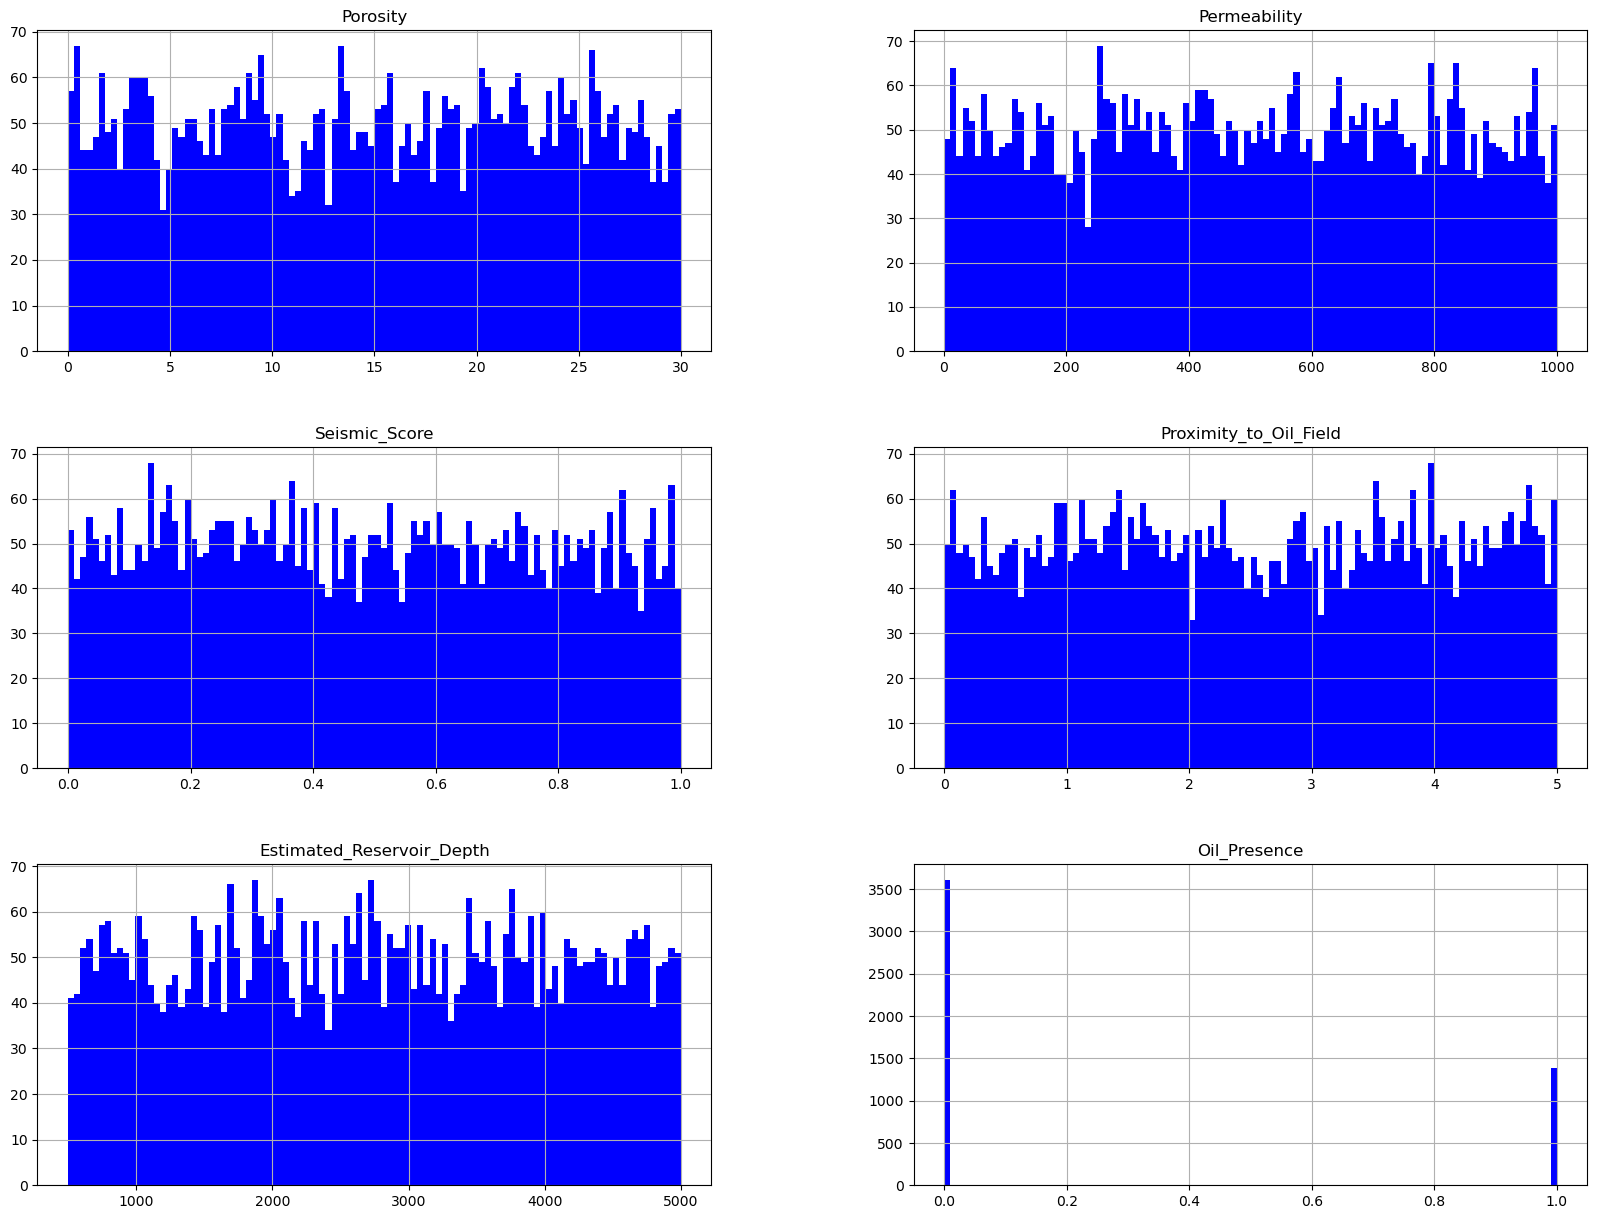

In [9]:
oil_data.hist(figsize=(20,15),color='blue', bins=100, alpha=1)

#### 😒 Our target is to predict Oil_presence--- but histogram shows a very critical problem of class imbalance means most values are 0, fewer are 1 so that our models could get biased toward 0 or that is predicting "no oil."

#### ✨ Lets check the imbalance first

In [10]:
oil_data['Oil_Presence'].value_counts()

Oil_Presence
0    3612
1    1388
Name: count, dtype: int64

##### 🤔 there is an imbalance of around 3:1

#### To fix imbalance we have several methods :                                                                            class_weight by using (class_weight='balanced'), random oversampling by using RandomOverSampler() as in this dataset imblance is high (3:1) so I am going to use *SMOTE Oversampling*

##### 😎 SMOTE = Synthetic Minority Oversampling Technique, which is a smart way to create fake but realistic examples of the minority class (oil presence) instead of just copying existing ones. From the library 'imbalanced-learn' I will use SMOTE() that will generate new minority samples

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [12]:
X = oil_data.drop('Oil_Presence', axis=1)   # features
y = oil_data['Oil_Presence']                # target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### 🧐Into this data set we have two columns with string values, Rock_Type and Trap_Type so before doing SMOTE we have to convert those string values into integer. So I will do one hot encoding

In [16]:
oil_data_encoded= pd.get_dummies(oil_data, columns=['Rock_Type','Trap_Type'],dtype=int ,drop_first= True)
oil_data_encoded.head(5)

,Porosity,Permeability,Seismic_Score,Proximity_to_Oil_Field,Estimated_Reservoir_Depth,Oil_Presence,Rock_Type_Sandstone,Rock_Type_Shale,Trap_Type_Dome,Trap_Type_Fault,Trap_Type_Unknown
0,0.438848,903.714252,0.181881,4.226811,1547,0,0,1,0,0,1
1,6.217269,111.883819,0.169586,0.583624,4878,0,1,0,0,1,0
2,21.397076,177.944336,0.862800,0.180588,1815,0,0,1,0,0,1
3,11.598605,429.236160,0.498148,3.042691,1886,0,0,1,1,0,0
4,19.874518,127.586022,0.245937,1.708715,4420,0,1,0,0,0,0


In [17]:
X = oil_data_encoded.drop('Oil_Presence', axis=1)   # features
y = oil_data_encoded['Oil_Presence']                # target

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
### Apply SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
### X_train_resampled--- the new balanced features dataset including original + synthetic samples.
### y_train_resampled--- the new balanced labels with same length as X_train_balanced.
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Oil_Presence
0    2890
1    1110
Name: count, dtype: int64
After SMOTE: Oil_Presence
1    2890
0    2890
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       722
           1       0.84      0.74      0.79       278

    accuracy                           0.89      1000
   macro avg       0.87      0.84      0.86      1000
weighted avg       0.89      0.89      0.89      1000

ROC-AUC: 0.8428027660973714

XGBoost Results:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       722
           1       0.78      0.75      0.76       278

    accuracy                           0.87      1000
   macro avg       0.84      0.83      0.84      1000
weighted avg       0.87      0.87      0.87      1000

ROC-AUC: 0.8339345144383108


In [ ]:
new_data = pd.DataFrame([
    [0.838848, 903.714252, 0.181881, 4.226811, 1547, 0, 1, 1, 0, 1],
    [0.217269, 111.883819, 0.169586, 0.883624, 4878, 1, 1, 0, 1, 0]
], columns=['Porosity', 'Permeability', 'Seismic_Score', 'Proximity_to_Oil_Field',
            'Estimated_Reservoir_Depth', 'Rock_Type_Sandstone', 'Rock_Type_Shale',
            'Trap_Type_Dome', 'Trap_Type_Fault', 'Trap_Type_Unknown'])

# Predict class labels class 0(no oil), class 1(oil)
pred_class = rf.predict(new_data)
print("Predicted classes:", pred_class)
# Predict probabilities (useful for ROC-AUC or confidence)
pred_proba = rf.predict_proba(new_data)[:, 1]  # probability of class 1
print("Predicted probabilities:", pred_proba)

Predicted classes: [0 0]
Predicted probabilities: [0.07 0.1 ]


In [31]:
from sklearn.metrics import confusion_matrix
# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

[[682  40]
 [ 72 206]]


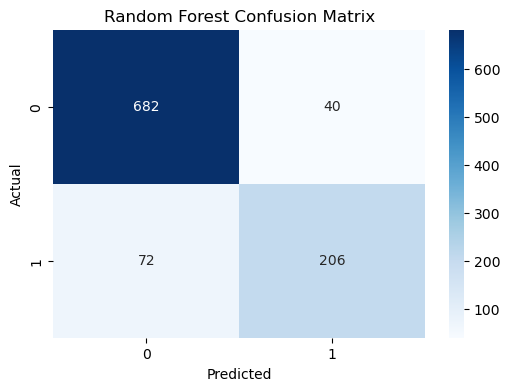

In [32]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()